In [1]:
import glob
from PIL import Image, ImageOps
import numpy as np
import cv2

from keyrover.vision import *
from keyrover import *
from keyrover.math import quad_area

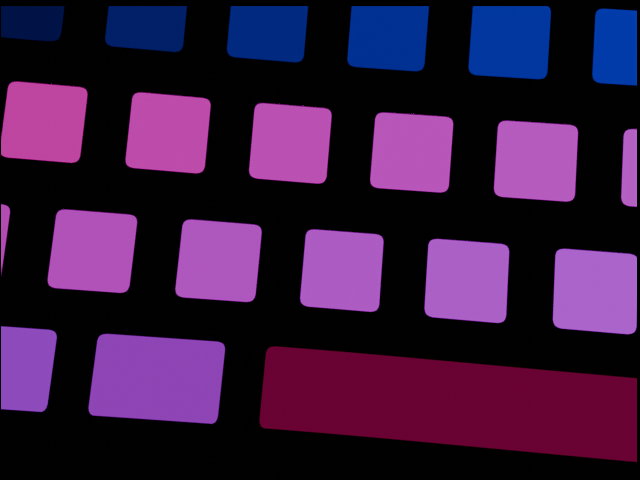

In [9]:
paths = glob.glob(f"{RAW_MASKS}/*.png")
mask_path = paths[3]
image_path = f"{SEGMENTATION_DATASET}/{os.path.basename(mask_path).removesuffix('.png')}.jpg"

image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("RGB")

binary = (np.array(mask.convert("L")) > 1).astype("uint8")
classes = np.array(mask)

Image.fromarray(classes)

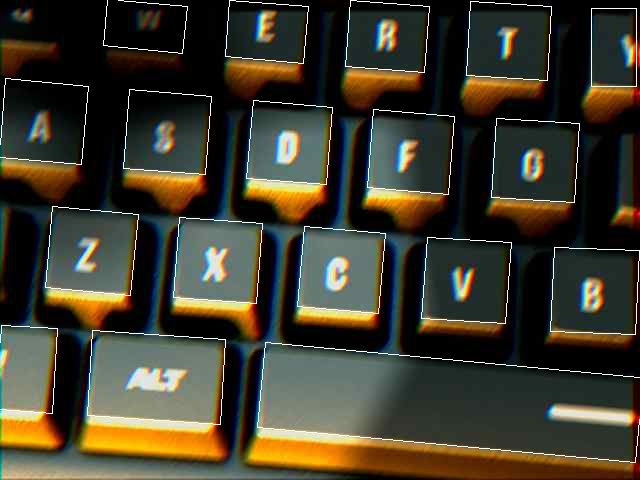

In [10]:
newimg = np.array(image)

OUTLIER_THRESHOLD = -0.5

rects = extract_rotated_rects(binary)
areas = np.array([quad_area(*rect.flatten()) for rect in rects])

d = areas - np.median(areas)
mdev = np.median(areas)
s = d / mdev if mdev else np.zeros(len(d))

rects = zip(s, rects)
rects = list(filter(lambda rect: rect[0] > OUTLIER_THRESHOLD, rects))

_, rects = zip(*rects)

for rect in rects:
    cv2.drawContours(newimg, [rect], -1, (255, 255, 255), 1)

Image.fromarray(newimg)

In [11]:
colors = set()

for rect in rects:
    crop = crop_rect(image, rect)
    binary_crop = crop_rect(binary, rect)

    crop = np.vstack(crop)
    crop = crop[binary_crop.flatten() == 1]
        
    color = tuple(np.quantile(crop, 0.75, axis=0))
    if color in colors:
        raise ValueError("Duplicate color detected")
    colors.add(color)

len(colors)

18